## Chapter 04. Reinforcement Learning

Gym 실습 (1) 환경

In [1]:
!pip install gym
# gym 설치

In [2]:
import gym
# gym 호출

In [3]:
env = gym.make('HotterColder-v0')
# gym에서 사용할 환경의 이름을 작성

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
env.reset()
# 환경 초기화 (상호작용할 준비, 초기 상태 0)
# -1000 ~ 1000 의 숫자를 찍어서 맞추기

0

In [5]:
import numpy as np

In [6]:
action = 0.0

In [7]:
observation, reward, done, info = env.step(np.array([action]))
# step을 통해 입력을 받아 다음의 상태를 확인
# np.array 형태로 action을 입력 (리스트 형태로 입력)
# observation: 정답보다 큰지 작은지 (환경에서 주어지는 정보)
# reward: 보상 (수식에 따른 계산값)
# done: 게임이 끝났는지 아닌지 (True면 게임 종료)
# info: 부가 정보 (강화 학습에 직접 사용X, 디버깅용)

In [8]:
observation

1

In [9]:
reward

0.5035605273488385

In [10]:
done

False

In [11]:
info
# 한 번 예측했으며, number는 정답

# 200번을 반복하게 되면 하나의 에피소드 완성

{'guesses': 1, 'number': 818.40990087821}

Gym 실습 (2) 에피소드

In [15]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=(1,))
])
# 하나의 에피소드를 수행하기 위해선, 하나의 모델을 만들어야 함
# 하나의 입력값을 받아 2가지 출력값을 내는 간단한 모델 구성

In [18]:
x = np.array([[1.0 if observation == 1 else -1.0]]) # 모델에 입력 (0,1,2,3) 4 가지가 입력되지만 0과 2는 없다고 판단 (0은 시작 값, 2는 정답)
# observation 이 1이면 1.0 아니면 -1.0 출력

In [19]:
logits = model(x)
logits
# up 에 해당하는 값 = 1.2041706
# down 에 해당하는 값 = 1.3209976
# softmax 함수에 넣으면 확률로 변환

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1.2041706, 1.3209976]], dtype=float32)>

In [20]:
tf.nn.softmax(logits)
# 모형에 activation = softmax 를 하지 않고 따로 처리
# tensorflow의 많은 함수들이 activation이 안 되어 있고, logits으로 받아 처리하는 함수들이 많음
# 확률적 정책이기 때문에 확률에 따라 랜덤하게 업다운을 진행

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.47082645, 0.52917355]], dtype=float32)>

In [22]:
index = tf.random.categorical(logits, num_samples=1)
# logits 값을 이용해 내부적으로 softmax 함수를 적용해 확률로 바꾼 뒤, 확률에 비율에 따라 랜덤하게 생성

In [23]:
# 지금까지는, index 변수와 0 번째 확률을 실현시킨 것
# REINFORCE 알고리즘을 적용하기 위해서
index = index[:, 0]
logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(index, logits) # 확률의 로그 값 (교차 엔트로피 식을 인덱스를 맞춰 사용), 랜덤하게 뽑은 쪽의 확률에 로그 씌우기 가능
# 이후 경사를 구하기 위해 GradientTape를 사용하는 함수를 정의

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6364388], dtype=float32)>

In [24]:
def play(env, model):
    step = 100 # +- 100 단위로 움직이게 설정
    env.reset()
    action = 0.0
    
    # 학습을 위한 기록
    grads = [] # 파라미터 업데이트를 위한 경사 기록
    rewards = []
    actions = []

    for i in range(200): # 200번 제한횟수만큼 반복
        observation, reward, done, info = env.step(np.array([action]))
        rewards.append(reward)

        if done:
            break

        x = np.array([[1.0 if observation == 1 else -1.0]])
        with tf.GradientTape() as tape:
            logits = model(x)
            index = tf.random.categorical(logits, num_samples=1)
            index = index[:, 0]
            logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(index, logits)
        grad = tape.gradient(logprob, model.trainable_weights) # logprob을 model의 파라미터로 미분 = 경사 구하기
        grads.append(grad)
        
        if index.numpy()[0] == 0: # index가 0이면 down
            action -= step
        else:
            action += step        # index가 1이면 up

        if action > 1000:         # action의 범위를 제한
            action = 1000
        if action < -1000:
            action = -1000
        actions.append(action)

    return {
        'actions': actions,
        'rewards': rewards,
        'grads': grads,
        'target': info['number']
    }

In [30]:
result = play(env, model)
result

{'actions': [-100.0,
  0.0,
  100.0,
  0.0,
  -100.0,
  0.0,
  -100.0,
  -200.0,
  -300.0,
  -200.0,
  -300.0,
  -400.0,
  -300.0,
  -200.0,
  -300.0,
  -400.0,
  -500.0,
  -600.0,
  -500.0,
  -600.0,
  -500.0,
  -600.0,
  -700.0,
  -600.0,
  -500.0,
  -600.0,
  -500.0,
  -600.0,
  -500.0,
  -600.0,
  -700.0,
  -600.0,
  -700.0,
  -600.0,
  -700.0,
  -800.0,
  -700.0,
  -800.0,
  -900.0,
  -1000.0,
  -900.0,
  -1000.0,
  -1000,
  -1000,
  -900,
  -1000,
  -900,
  -800,
  -700,
  -800,
  -900,
  -800,
  -900,
  -800,
  -900,
  -800,
  -900,
  -1000,
  -900,
  -800,
  -700,
  -800,
  -900,
  -800,
  -900,
  -1000,
  -1000,
  -1000,
  -900,
  -1000,
  -1000,
  -900,
  -800,
  -700,
  -600,
  -500,
  -600,
  -700,
  -800,
  -900,
  -800,
  -700,
  -800,
  -700,
  -600,
  -700,
  -800,
  -700,
  -800,
  -700,
  -600,
  -700,
  -800,
  -900,
  -800,
  -900,
  -1000,
  -900,
  -1000,
  -1000,
  -900,
  -1000,
  -1000,
  -1000,
  -1000,
  -900,
  -800,
  -900,
  -1000,
  -900,
  -1000,
  -900,

In [26]:
import matplotlib.pyplot as plt

In [27]:
actions = result['actions']
target = result['target']

In [28]:
t = np.arange(len(actions))
# episode의 길이 (가로축)

(-1000.0, 1000.0)

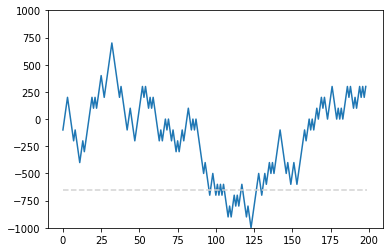

In [29]:
plt.plot(t, actions)
plt.plot([0, 199], [target, target], linestyle='dashed', color='lightgrey') # 정답; 회색의 점선
plt.ylim(-1000, 1000)

Gym 실습 (3) REINFORCE 구현

In [31]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
# 경사상승법 알고리즘 SGD 사용
# 경사상승법은 손실 함수에 - 붙히지만, 상승법에서는 그대로 사용

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=(1, ))                             
])
# 모델을 재사용하기 번거롭기 때문에, 다시 한 번 정의

In [33]:
model.trainable_weights
# 두 종류의 출력
# kernel : 입력값에 곱해지는 것
# bias : 출력에 더해지는 부분
# 출력의 종류가 늘어난다면?

[<tf.Variable 'dense_1/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[-1.0754551 , -0.91890883]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

In [39]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, input_shape=(1, ))                             
])
model2.trainable_weights

[<tf.Variable 'dense_2/kernel:0' shape=(1, 4) dtype=float32, numpy=
 array([[ 0.6995666 ,  0.30662537, -0.44211614,  0.18739927]],
       dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]

In [34]:
tf.nn.softmax(model(np.array([[1.0], [-1.0]])))
# 작다고 나오면 53%의 확률로 올리고, 위의 행은 정답보다 작게 예측한 경우의 (내려가는 확률, 올라가는 확률)
# 크다고 나오면 53%의 확률로 내림,   아래의 행은 정답보다 크게 예측한 경우의 (내려가는 확률, 올라가는 확률)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.46094316, 0.53905684],
       [0.53905684, 0.46094316]], dtype=float32)>

(-1000.0, 1000.0)

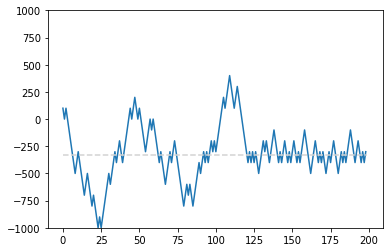

In [38]:
result = play(env, model) 
# 별도의 학습이 없어도 초기값이 잘 잡혀있다면, 학습을 진행
# 초기 값을 변환시키기 위해서 다시 모형을 설정하면 됨 (다른 방법은 없는가?)
plt.plot(t, result['actions'])
plt.plot([0, 199], [result['target'], result['target']], linestyle='dashed', color='lightgrey')
plt.ylim(-1000, 1000)

In [36]:
rewards = result['rewards'][1:]
# 0으로 시작한 것의 reward까지 포함되어 있어서 gradient는 첫 번째는 고정이라 제외하고 199개이기 때문에 reward도 처음을 빼고 계산

In [37]:
# param <- param + G * gradient logprob
# G 만 정해주면 됨 (rewards를 그대로 return 값으로 활용 등)
# 할인이 0이라고 가정하면 return과 reward가 동일해짐
for reward, grad in zip(rewards, result['grads']):
    update = [(reward - 0.5) * g for g in grad] # grad는 하나의 입력을 받아 두 개의 출력을 나타내기 때문에, 계산을 두 번 해줘야함
                                                # 확률이 반대로 되어 있을 경우, reward가 0~1 사이의 +이기 때문에 바깥쪽으로 벗어나도 보상이 + 이므로 학습이 불안정
                                                # 학습을 안정화시키기 위해 기저선으로 0.5를 설정
    optimizer.apply_gradients(zip(update, model.trainable_weights)) # 각각의 파라미터에 reward를 더해줌

자연어 생성에 강화학습 적용

In [40]:
# GPT2를 이용한 자연어 생성에서 강화 학습을 통해 같은 단어가 반복되는 문제를 억제
!pip install transformers

     |████████████████████████████████| 2.3MB 27.3MB/s 
     |████████████████████████████████| 3.3MB 49.9MB/s 
     |████████████████████████████████| 901kB 44.6MB/s 


In [41]:
import tensorflow as tf
from transformers import TFAutoModelForCausalLM, AutoTokenizer

In [42]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = TFAutoModelForCausalLM.from_pretrained('gpt2')

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [43]:
input_ids = tokenizer.encode('I like this movie', return_tensors='tf')
# 모형에 문장을 넣어, 이후에 나올 단어를 형성

In [44]:
result = model.generate(input_ids, max_length=50)
# 최대 길이 50으로 이어지는 문장을 생성
# greedy method를 통해 생성하게 됨 (가장 확률이 높은 단어순으로 이어 붙히게 됨)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [45]:
tokenizer.decode(result[0])
# 결과를 문장 형태로 변환
# 학습 단계에선 억제하기 어렵기 때문에, 생성 단계에서 대응하게 됨 (지도 학습)

"I like this movie. I like the way it's set up. I like the way it's set up. I like the way it's set up. I like the way it's set up. I like the way it's set up."

In [46]:
res = result[0]
# 같은 표현이 얼마나 반복되는지 점수화를 해야함
# 타겟 문장을 변수로 지정

In [47]:
from collections import Counter
# 같은 단어의 반복보다 일정 표현의 반복이 문제가 큼 (tri-gram 등)
# 같은 세 단어가 얼마나 나왔는가?
# 갯수를 셀 때 사용할 수 있는 사전 (Counter) = 기본 값이 있어서 한 번 나올 때마다 Counter에 1씩 더해줌

In [48]:
def score(res):
    counter = Counter() # Counter 초기화
    tokens = res.numpy() # tensor flow 형식을 numpy 형식으로 변환
    for i in range(0, len(tokens) - 3): # 3 개 토큰을 단위로 측정하기 때문에 -3
        trigram = tokens[i:i+3] # 0부터 3까지 기록하며 trigram 탐색
        trigram = tuple(trigram) # dictionary에 입력하기 위해 튜플 형식으로 변환
        counter[trigram] += 1 # 토큰의 번호와 반복 횟수를 기록 (counter 변수)
    return len(counter) / sum(counter.values()) # 세 단어 조합의 종류 / 세 단어 조합의 총 갯수

In [49]:
score(res) # 14/47
# 27%만 새로운 trigram 이며, 나머지는 반복
# 이 점수를 높이도록 강화 학습 진행

0.2765957446808511

In [50]:
with tf.GradientTape() as tape:
    output = model(result, labels=result) # 내장된 교차엔트로피 계산 함수, 모델에 입력할 때 정답을 넣어주면 교차 엔트로피 계산, 정답이 따로 없기 때문에 자기 자신과 비교
    s = score(result[0])
    loss = (s - 0.5) * output[0] # 점수와 교차 엔트로피의 곱, 점수의 계산이 복잡하기 때문에 예제이므로 점수를 return 이라고 판단
    # s가 문장의 반복을 고려하는데, 이러한 학습을 실제로 적용하면, 반복만 적게 되고 말이 안되는 문장을 고안할 수 있음
    mean_loss = tf.reduce_mean(loss) # 손실의 평균을 구함

In [51]:
grads = tape.gradient(mean_loss, model.trainable_variables) # 경사를 구함

In [52]:
opt = tf.keras.optimizers.Adam(learning_rate=5e-4, epsilon=1e-08) # 학습 알고리즘 설정

In [53]:
opt.apply_gradients(zip(grads, model.trainable_variables)) # 경사 적용

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [54]:
result = model.generate(input_ids, max_length=50) # 문장 생성

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [55]:
tokenizer.decode(result[0]) # 생성된 문장 확인

'I like this movie:\n\n"The first time I saw the video, I was shocked," said Mr. Karpinski, who was born in Moscow in 1991. "It was a very beautiful moment."\n\nThe Russian government has been'